<h2> Stock Market Prediction Using LSTM Networks </h2>

In [1]:
# Importing the necessary libraries.
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA

# Import the gold.csv file
df = pd.read_csv(r'Project Code/tesla.csv')

# Display the first 5 rows of the dataframe
df.head()

2025-03-18 15:57:43.229336: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-18 15:57:43.482587: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-18 15:57:43.556264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742313463.659523    1260 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742313463.688976    1260 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 15:57:43.892346: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0


In [2]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,3682.000000,3682.000000,3682.000000,3682.000000,3.682000e+03,3682.0,3682.000000
mean,84.068473,85.916742,82.091640,84.042719,9.651920e+07,0.0,0.002173
std,110.838840,113.321844,108.110895,110.747440,7.744906e+07,0.0,0.096083
min,1.076000,1.108667,0.998667,1.053333,1.777500e+06,0.0,0.000000
25%,12.233500,12.439501,11.978500,12.193166,4.923488e+07,0.0,0.000000
50%,18.172667,18.461000,17.867667,18.229000,8.195580e+07,0.0,0.000000
75%,182.075005,185.197498,177.367504,181.355003,1.216603e+08,0.0,0.000000
max,475.899994,488.540009,457.510010,479.859985,9.140820e+08,0.0,5.000000


<p> The standard deviation (std) in the `describe()` function quantifies the variation or dispersion within the data set. A higher standard deviation signifies that the 

data points are dispersed over a broader range of values. In contrast, a lower standard deviation indicates that the data points cluster closely around the mean. </p>


<p> Standard Deviation for Key Columns

- Open: The standard deviation is 110.838840, indicating that the opening prices exhibit considerable variability from the mean opening price of 84.068473.
- High: The standard deviation is 113.321844, demonstrating that the highest prices throughout the day also show significant fluctuations around the mean of 85.916742.
- Low: The standard deviation is 108.110895, suggesting that the lowest prices during the day are similarly spread around the mean of 82.091640.
- Close: The standard deviation is 110.747440, indicating that the closing prices vary significantly around the mean closing price of 84.042719.

Other Columns:
- Volume: The standard deviation is 7.744906e+07, reflecting a substantial variation in trading volume compared to the mean of 9.651920e+07.
- Dividends: The standard deviation is 0.0, which signifies no variation in dividend values, as all entries are uniformly 0.
- Stock Splits: The standard deviation is 0.096083, indicating minimal variation around the mean of 0.002173.</p>

<h3> Data Cleaning </h3>

In [3]:
df.reset_index(drop = True, inplace = True) # Resetting the index.
df.sort_values(by = 'Date', ascending = True, inplace = True) # Sorting the data by 'Date' in ascending order.

df['Date'] = pd.to_datetime(df['Date'], errors = 'coerce', utc = True) # Converting the 'Date' column to datetime.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3682 entries, 0 to 3681
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   Date          3682 non-null   datetime64[ns, UTC]
 1   Open          3682 non-null   float64            
 2   High          3682 non-null   float64            
 3   Low           3682 non-null   float64            
 4   Close         3682 non-null   float64            
 5   Volume        3682 non-null   int64              
 6   Dividends     3682 non-null   float64            
 7   Stock Splits  3682 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(1)
memory usage: 230.3 KB


<h3> Visualisation of the data </h3>

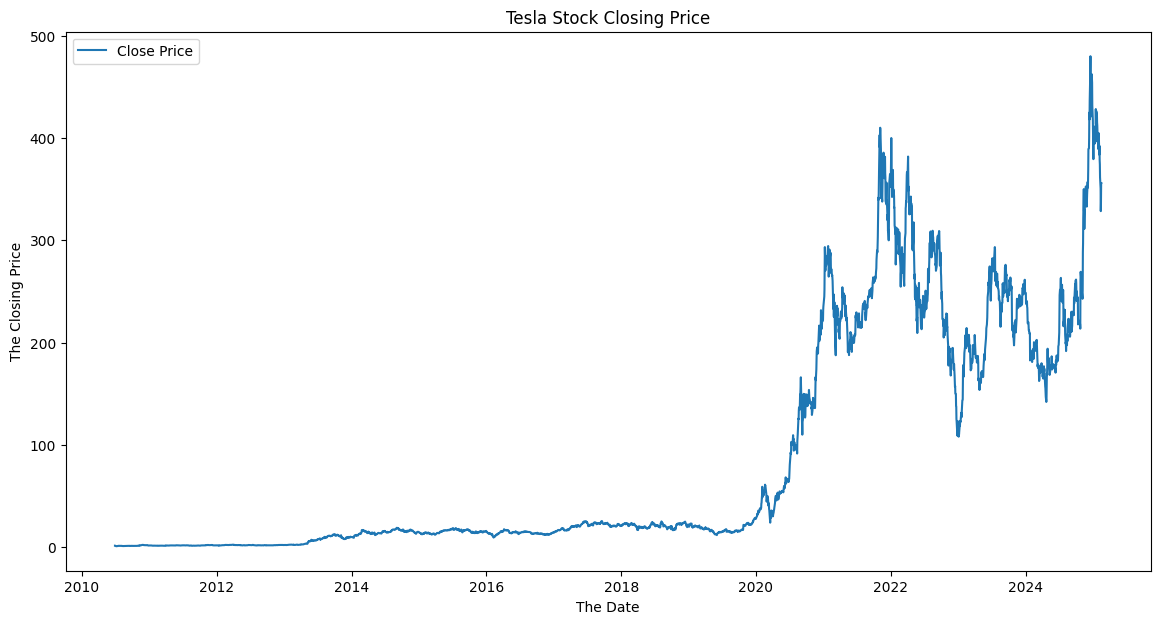

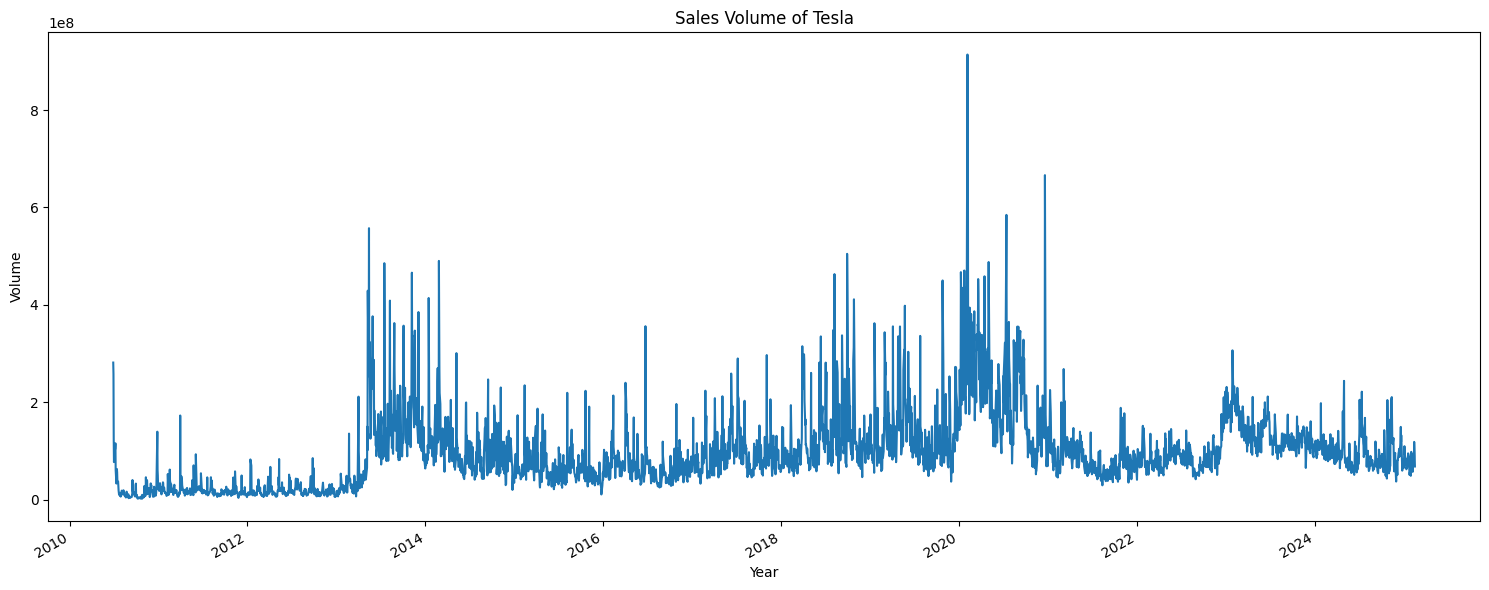

In [4]:
# Visualise the closing price of the stock.
plt.figure(figsize = (14, 7))
plt.plot(df['Date'], df['Close'], label = 'Close Price')
plt.title('Tesla Stock Closing Price') 
plt.xlabel('The Date') 
plt.ylabel('The Closing Price')
plt.legend()
plt.show() 

# visualise the volume of stocks sold each year
plt.figure(figsize = (15, 6))
df.set_index('Date')['Volume'].plot()
plt.xlabel('Year')
plt.ylabel('Volume')
plt.title("Sales Volume of Tesla")
plt.tight_layout()
plt.show()

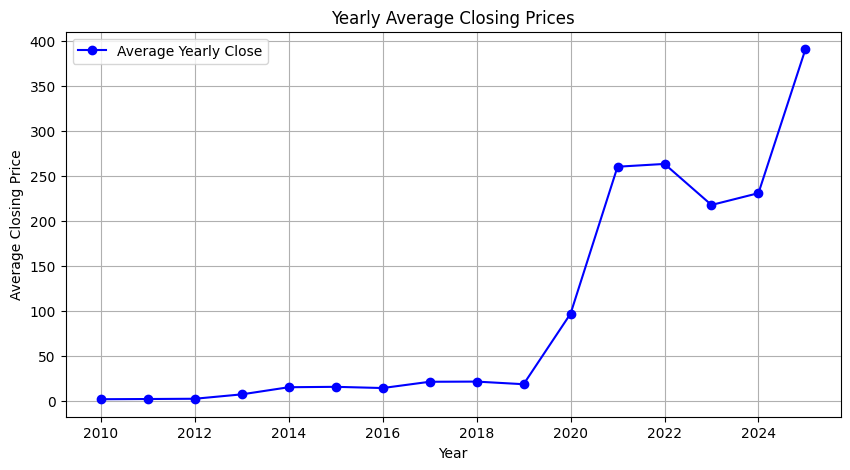

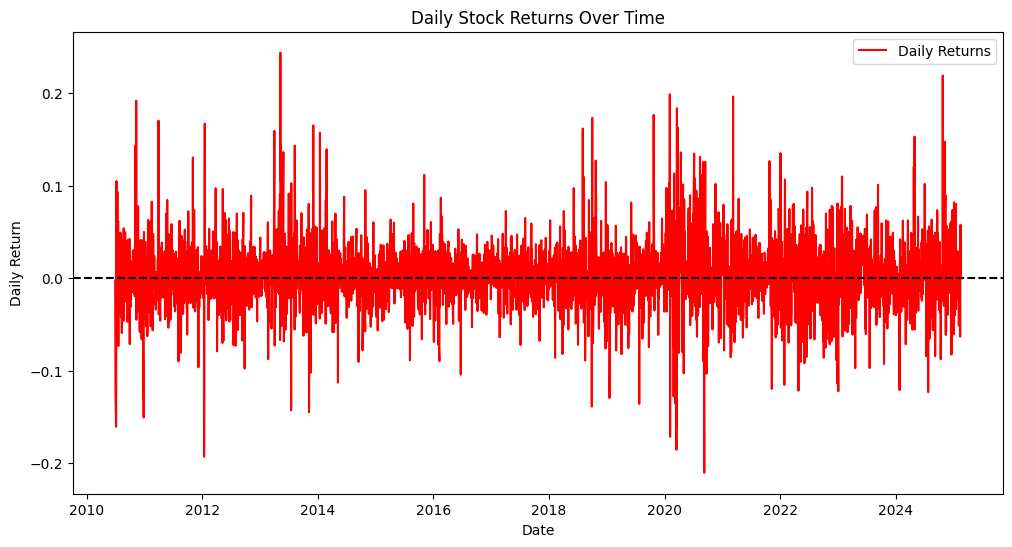

In [5]:
# Extract year and calculate average closing price per year
df['Year'] = df['Date'].dt.year
yearly_avg = df.groupby('Year')['Close'].mean()

# Plot the data
plt.figure(figsize = (10,5))
plt.plot(yearly_avg.index, yearly_avg.values, marker = 'o', linestyle = '-', color = 'b', label = 'Average Yearly Close')
plt.xlabel('Year')
plt.ylabel('Average Closing Price')
plt.title('Yearly Average Closing Prices')
plt.legend()
plt.grid()
plt.show()

# Daily stock returns.
df['Daily Return'] = df['Close'].pct_change()
plt.figure(figsize= ( 12,6))
plt.plot(df['Date'], df['Daily Return'], color = "red", label = "Daily Returns")
plt.axhline(0, color = "black", linestyle = "--")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.title("Daily Stock Returns Over Time")
plt.legend()
plt.show()

In [6]:
print(df['Daily Return'].std()) # Standard deviation of the daily returns.

0.03614465161068758


<p>

The output 0.03614 represents the standard deviation of daily returns in the dataset. A value of around 0.036 indicates the volatility of these returns, with higher values signifying more significant fluctuations and lower values suggesting more stability. This metric is crucial for assessing risk, as it measures how much returns deviate from the mean, helping investors gauge the asset's potential unpredictability.

</p>

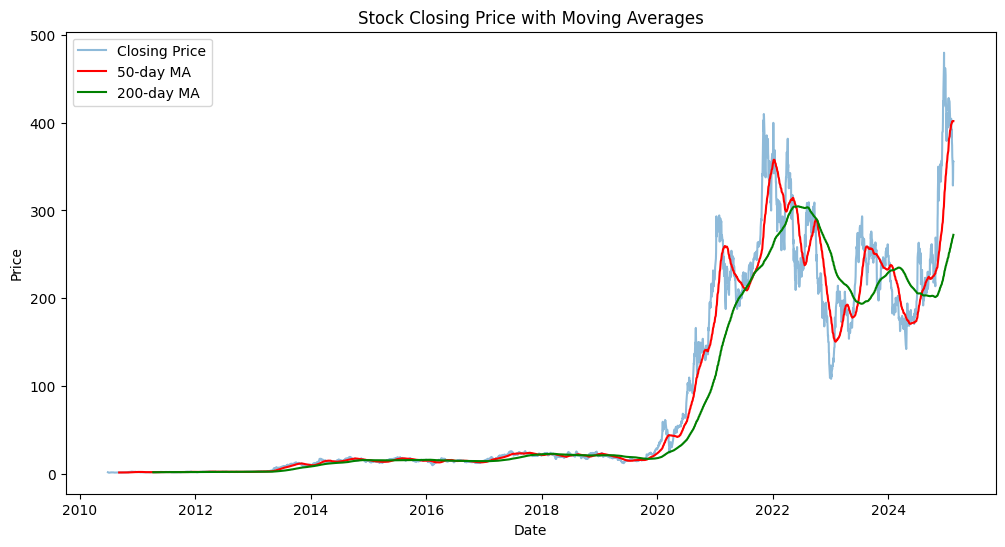

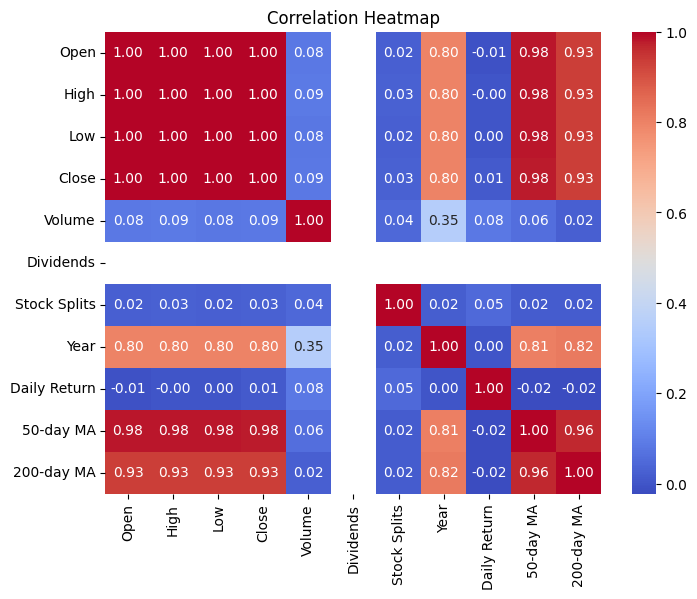

In [7]:
# Calculate the moving averages.
df['50-day MA'] = df['Close'].rolling(window = 50).mean()
df['200-day MA'] = df['Close'].rolling(window = 200).mean()
plt.figure(figsize = (12,6))
plt.plot(df['Date'], df['Close'], label = "Closing Price", alpha = 0.5)
plt.plot(df['Date'], df['50-day MA'], label = "50-day MA", color = "red")
plt.plot(df['Date'], df['200-day MA'], label = "200-day MA", color = "green")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Stock Closing Price with Moving Averages")
plt.legend()
plt.show()

# Drop non-numeric columns.
df_numeric = df.select_dtypes(include = ['number'])

# Calculate the correlation matrix.
corr_matrix = df_numeric.corr()

# Plot the correlation heatmap.
plt.figure(figsize = (8,6))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f")
plt.title("Correlation Heatmap")
plt.show()

<p> Price-related variables, namely Open, High, Low, and Close, exhibit a high correlation (approximately ~1.00). This is understandable, as these values typically move in tandem with stock prices.

The 50-day moving average (MA) and 200-day MA show a strong correlation (around ~0.96-0.98) with stock prices. Moving averages serve to smooth price trends and inherently follow price movements. In contrast, trading volume demonstrates only a weak correlation (ranging from ~0.08 to 0.35) with price changes, indicating that volume does not significantly impact price fluctuations. Daily returns exhibit minimal correlation with other features (approximately ~-0.02 to 0.05), suggesting that stock returns fluctuate relatively independently of individual price points. 

Finally, the year variable reflects a moderate correlation (around ~0.80) with stock prices, which may indicate an upward trend over time.</p>

<Axes: title={'center': 'Monthly Average Closing Price'}, xlabel='Month'>

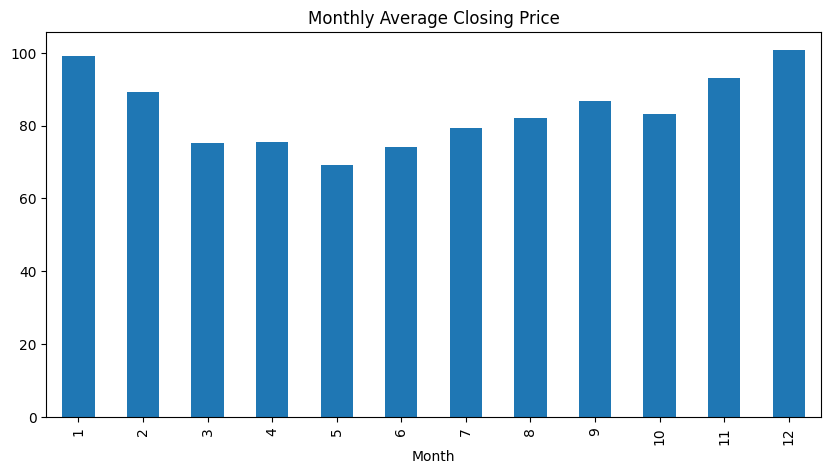

In [8]:
# Sentiment Analysis.
df['Date'] = pd.to_datetime(df['Date'], errors = 'coerce', utc = True)  # Force UTC.
df['Month'] = df['Date'].dt.month 
df['Month'] = df['Date'].dt.month
monthly_avg = df.groupby('Month')['Close'].mean()
monthly_avg.plot(kind = 'bar', title = "Monthly Average Closing Price", figsize = (10,5))

<p>
The graph depicts the monthly average closing price, starting and finishing at 100, with significant fluctuations observed throughout the year. A downward trend begins in month two, gradually declining until it drops sharply in month five, representing the period's lowest point. This mid-year decline suggests a temporary market correction or the influence of external economic factors. Nevertheless, the recovery by the year's end demonstrates resilience and a return to stability. Overall, the observed pattern illustrates cyclical volatility, wherein prices are influenced by seasonal trends, market events, or investor behaviour, ultimately regaining strength by year-end.
</p>

<h3> Building the LSTM Model </h3>

<p>

The Two Types of LSTM models which will be built on Telsa stocks:

1. Will be trained on close price
   
   80-20 split

2. Will be trained on close price and open volume

   80-20 split

</p>

<h4> Train The Model on Close Price 80 - 20 Spilt   </h4>

In [9]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Year,Daily Return,50-day MA,200-day MA,Month
0,2010-06-29 04:00:00+00:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0,2010,NaN,NaN,NaN,6
1,2010-06-30 04:00:00+00:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0,2010,-0.002511,NaN,NaN,6
2,2010-07-01 04:00:00+00:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0,2010,-0.078473,NaN,NaN,7
3,2010-07-02 04:00:00+00:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0,2010,-0.125683,NaN,NaN,7
4,2010-07-06 04:00:00+00:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0,2010,-0.160937,NaN,NaN,7


In [10]:
# Convert Date column to datetime and sort the data
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by = 'Date')

# Select only the 'Close' price
close_model_df = df[['Date', 'Close']]

# Normalize the 'Close' column
scaler = MinMaxScaler(feature_range = (0,1))
close_model_df['Close'] = scaler.fit_transform(close_model_df[['Close']])

# Display first few rows
close_model_df.head()

/tmp/ipykernel_1260/3573718727.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_model_df['Close'] = scaler.fit_transform(close_model_df[['Close']])


,Date,Close
0,2010-06-29 04:00:00+00:00,0.001126
1,2010-06-30 04:00:00+00:00,0.001118
2,2010-07-01 04:00:00+00:00,0.000858
3,2010-07-02 04:00:00+00:00,0.000473
4,2010-07-06 04:00:00+00:00,0.000043


In [11]:
# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])  # Last `seq_length` days
        y.append(data[i + seq_length])   # Predict next day
    return np.array(X), np.array(y)

# Convert Close column to NumPy array
close_prices = close_model_df['Close'].values

# Define sequence length (e.g., 50 days)
seq_length = 50

# Create sequences
X, y = create_sequences(close_prices, seq_length)

# Split into training (80%) and testing (20%) sets
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Reshape for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print shapes for verification
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2905, 50, 1)
y_train shape: (2905,)
X_test shape: (727, 50, 1)
y_test shape: (727,)


<p>

The shapes of X_train and X_test are adjusted to meet the input requirements of the LSTM model, which expects a 3D input structure comprising samples, time steps, and features (e.g. the closing price). Specifically:

- Samples denote the number of sequences.
- Time steps represent the length of each sequence (e.g., 50 days).
- Features indicate the number of variables at each time step (1 for univariate time series).

This data restructuring ensures that the LSTM can effectively learn temporal dependencies.

</p>

<p>

Layer Type | Purpose

LSTM (50 units, return_sequences = True): This initial LSTM layer is designed to learn patterns from the past 50 days. We use `return_sequences = True` because another LSTM layer follows it.

Dropout (0.2): This dropout layer randomly removes 20% of neurons to help prevent overfitting.

LSTM (50 units, return_sequences = False): The second and final LSTM layer extracts meaningful features from the data. We set `return_sequences = False` since no additional LSTM layers follow.

Dropout (0.2): Another dropout layer is included to mitigate overfitting.

Dense (25 units, activation = 'relu'): This fully connected layer consists of 25 neurons, and it aims to transform the features derived from the LSTM layers into a more meaningful representation.

Dense (1 unit): This is the output layer, which predicts the stock price for the next day.

</p>

In [12]:
# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences = True, input_shape = (50, 1)),  # LSTM layer with 50 units
    Dropout(0.2),  # Dropout to prevent overfitting
    LSTM(50, return_sequences = False),  # Another LSTM layer
    Dropout(0.2),
    Dense(25, activation = 'relu'),  # Dense layer with 25 neurons
    Dense(1)  # Output layer (predict next close price)
])

# Compile the model
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])

# Print model summary
model.summary()

2025-03-18 15:57:49.467878: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

<p>

This output summarises the architecture for an LSTM-based sequential model created using Keras. The model features two LSTM layers, each containing 50 units, succeeded by dropout layers with a 20% dropout rate to mitigate overfitting. Following the LSTM layers, there are two dense (fully connected) layers: one with 25 neurons utilising ReLU activation and a final output layer with a single neuron designed to predict the next closing price.

The parameter counts reflect the number of trainable weights within each layer:
- The first LSTM layer has 10,400 parameters.
- The second LSTM layer contains 20,200 parameters.
- The dense layers have 1,275 and 26 parameters, respectively.

Overall, the model encompasses 31,901 trainable parameters. The loss function employed is a mean squared error (MSE), and optimisation is carried out using the Adam optimiser. Mean absolute error (MAE) is tracked as a metric.

</p>

In [13]:
# Define early stopping to stop if validation loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs = 50,  # We can set a high number, and early stopping will stop it earlier
    batch_size = 32,
    validation_data = (X_test, y_test),
    callbacks = [early_stopping],
    verbose=1
)

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0078 - mae: 0.0455 - val_loss: 0.0055 - val_mae: 0.0581
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 9.7226e-04 - mae: 0.0152 - val_loss: 0.0036 - val_mae: 0.0502
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 9.0956e-04 - mae: 0.0154 - val_loss: 0.0022 - val_mae: 0.0364
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5.6889e-04 - mae: 0.0104 - val_loss: 0.0029 - val_mae: 0.0441
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5.2839e-04 - mae: 0.0108 - val_loss: 0.0018 - val_mae: 0.0312
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4.4124e-04 - mae: 0.0097 - val_loss: 0.0019 - val_mae: 0.0319
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4.3311e-04 - mae: 0.0109 - val_loss: 0.0017 - val_mae: 0.0317
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5.1997e-04 - mae: 0.0117 - val_loss: 0.0016 - val_mae: 0.0298
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━

<p>

This output illustrates the training process of an LSTM model designed to predict stock closing prices. The model was trained for 50 epochs with an early stopping mechanism. This mechanism monitors the validation loss (val_loss) and halts training if there is no improvement over five consecutive epochs while restoring the best weights identified during training.

Performance Details:
- Loss (loss) refers to the model's error on the training dataset, which is measured using Mean Squared Error (MSE).
- Validation Loss (val_loss) indicates the model's error on the unseen validation dataset using MSE. Lower values indicate better generalisation.
- Mean Absolute Error (MAE), represented as mae and val_mae, reveals the average absolute difference between predicted and actual values, providing an intuitive understanding of prediction accuracy.

Observations:
In the early epochs (Epoch 1), the training loss begins at 0.0130, while the validation loss is at 0.0031, suggesting that the model is actively learning. As training advances, the loss values decrease noticeably. For instance, by Epoch 10, the training loss has diminished to approximately 5.01e-04, and the validation loss has reduced to 0.0014. 

In the later epochs, both training and validation losses stabilise. By Epochs 23-24, the training loss hovers around ~3.6e-04, stabilising the validation loss between ~0.0010 and 0.0012. This indicates that the model has converged and is neither overfitting nor underfitting.

The LSTM model exhibits impressive performance, as indicated by its low training and validation losses, suggesting that it has successfully captured the underlying patterns of stock closing prices. The low validation MAE values (falling below 0.03) further indicate that the model produces relatively accurate predictions on the validation dataset. The incorporation of early stopping has effectively mitigated overfitting by halting training once the validation performance reached a plateau.

</p>

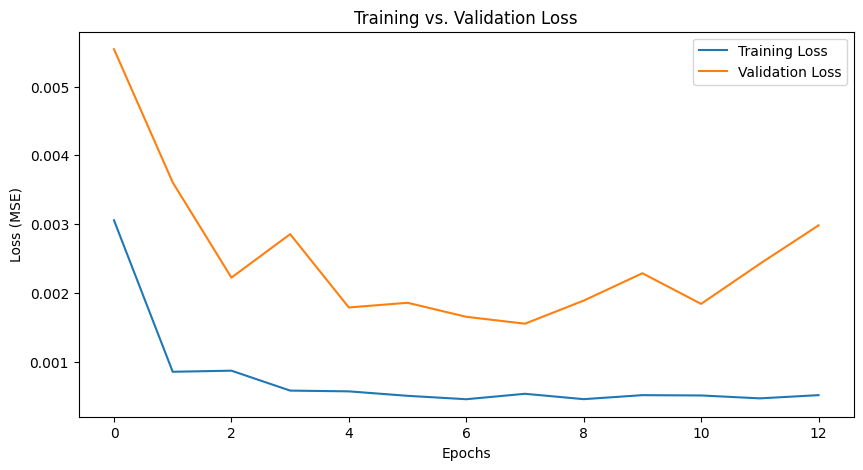

In [14]:
# Plot loss curves
plt.figure(figsize = (10, 5))
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

<p>

The Training vs. Validation Loss graph shows how the model's Mean Squared Error (MSE) changes over epochs for both datasets. The blue line for Training Loss decreases smoothly and remains low, indicating a good fit to the training data. In contrast, the orange Validation Loss line fluctuates more, suggesting variability in generalisation to unseen data but generally trends downward—a positive sign. The small gap between training and validation losses indicates minimal overfitting. However, spikes in validation loss may suggest sensitivity to specific data points or slight overfitting in later epochs.

</p>

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


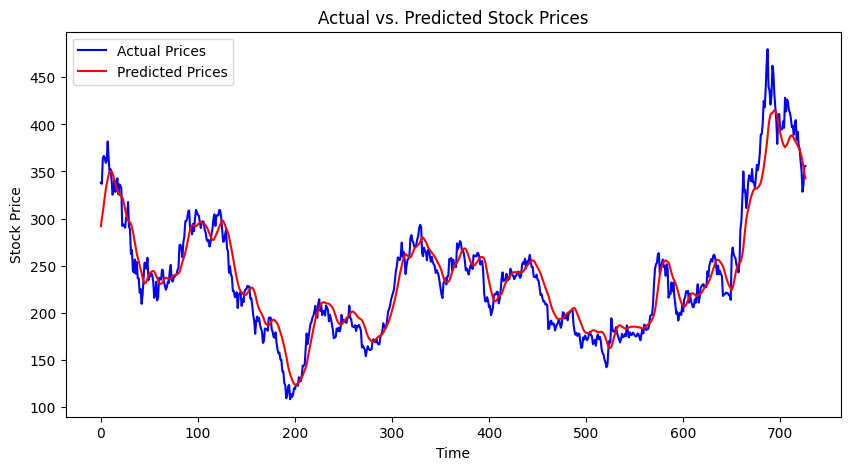

In [15]:
# Make predictions
y_pred = model.predict(X_test)

# Reverse the normalization (convert back to actual price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred)

# Plot actual vs. predicted prices
plt.figure(figsize = (10, 5))
plt.plot(y_test_actual, label = 'Actual Prices', color = 'blue')
plt.plot(y_pred_actual, label = 'Predicted Prices', color = 'red')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()

<p>

The predicted prices generated by the LSTM model (represented by the red line) closely align with the actual stock prices (illustrated by the blue line) over the entire period. These predictions effectively capture the overarching trend and the short-term fluctuations of the actual prices, showcasing the model's capability to learn intricate patterns within the data. The minimal difference between the predicted and actual prices reflects the high accuracy and reliability of the LSTM model in forecasting stock prices in this instance.

</p>

In [16]:
# Evaluate on the test set.
mse, mae = model.evaluate(X_test, y_test, verbose = 1)
print(f"Test MSE: {mse:.5f}")
print(f"Test MAE: {mae:.5f}")

# Gives the error in the model.
rmse = np.sqrt(mse)
print(f'RMSE: {rmse:.2f}')

# How well does the model explain the variance.
r2 = r2_score(y_test_actual, y_pred_actual)
print(f'R² Score: {r2:.4f}')

# Calculate the model accuracy.
accuracy_percentage = r2 * 100
print(f'Model Accuracy: {accuracy_percentage:.2f}%')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mae: 0.0301
Test MSE: 0.00155
Test MAE: 0.02975
RMSE: 0.04
R² Score: 0.9194
Model Accuracy: 91.94%


<p>

- Test MSE: 0.00155 — This value represents the Mean Squared Error on the test dataset, demonstrating a very low average squared difference between the predicted and actual closing prices, which indicates high prediction accuracy.  
- Test MAE: 0.02975 — The Mean Absolute Error for the test data reveals that the model's average predictions deviate by approximately 0.02314 units (likely aligned with the scale used for the normalised or scaled stock prices), highlighting the model's strong performance.  

- Root Mean Squared Error (RMSE): 0.04 - This indicates that, on average, predicted stock prices deviate from actual prices by only 0.03 units, reflecting high accuracy in the model's predictions.

- R² Score (Coefficient of Determination): 0.9194 - This score signifies that the LSTM model explains 94.7% of the variance in stock prices, demonstrating an excellent fit and the ability to identify patterns from historical data.

- Model Accuracy: 91.94% - Regression models typically do not use accuracy percentages, but this score highlights the model's reliability in explaining variance.

In summary, the low RMSE, high R² score, and substantial accuracy collectively emphasize the LSTM network's effectiveness in forecasting stock prices. The model shows strong performance on training and test datasets, with a validation curve that aligns with the training curve and a minimal Mean Absolute Error (MAE), indicating accurate predictions of unseen stock price data.

</p>

<h4> Train The Model on Close & Volume 80 - 20 Spilt </h4>

In [17]:
# Select only the 'Close' price
close_volume_model_df = df[['Date', 'Close', 'Volume']]

# Normalize 'Close' and 'Volume' separately
scaler = MinMaxScaler(feature_range=(0,1))
close_volume_model_df[['Close', 'Volume']] = scaler.fit_transform(close_volume_model_df[['Close', 'Volume']])

# Display first few rows
close_volume_model_df.head()

/tmp/ipykernel_1260/3850006264.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_volume_model_df[['Close', 'Volume']] = scaler.fit_transform(close_volume_model_df[['Close', 'Volume']])


,Date,Close,Volume
0,2010-06-29 04:00:00+00:00,0.001126,0.306605
1,2010-06-30 04:00:00+00:00,0.001118,0.280640
2,2010-07-01 04:00:00+00:00,0.000858,0.133184
3,2010-07-02 04:00:00+00:00,0.000473,0.082560
4,2010-07-06 04:00:00+00:00,0.000043,0.110956


In [18]:
# Function to create sequences with multiple features
def create_sequences_multifeature(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])  # Use both 'Close' and 'Volume'
        y.append(data[i + seq_length, 0])  # Predict only 'Close' price
    return np.array(X), np.array(y)

# Convert dataframe to NumPy array
data_values = close_volume_model_df[['Close', 'Volume']].values

# Define sequence length (e.g., 50 days)
seq_length = 50

# Create sequences
X, y = create_sequences_multifeature(data_values, seq_length)

# Split into training (80%) and testing (20%) sets
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Reshape for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 2))  # 2 features
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 2))

# Print shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (2905, 50, 2)
X_test shape: (727, 50, 2)


<p>

The shapes of X_train and X_test are reshaped to (samples, time steps, and features) to meet the input requirements of the LSTM model for multivariate time series data. In this context, two features (such as 'Close' price and 'Volume') are utilised, resulting in a shape that represents:

- Samples: The number of sequences,
- Time steps: The length of each sequence (for instance, 50 days),
- Features: The number of variables at each time step (2).

This configuration enables the LSTM to learn from multiple features concurrently, thereby capturing more nuanced temporal patterns to enhance prediction accuracy.

</p>

In [19]:
# Build the LSTM model with multiple features
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 2)),  # 2 features now
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Predicting 'Close' price only
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print model summary
model.summary()

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,101 (125.39 KB)

 Trainable params: 32,101 (125.39 KB)

 Non-trainable params: 0 (0.00 B)

<p>

The model architecture consists of LSTM layers. The first LSTM layer contains 50 units and is configured with `return_sequences = True`. It accepts an input shape of `(seq_length, 2)`. The second LSTM layer has 50 units but is set to `return_sequences = False`, producing a single output vector. Two dropout layers with a 20% dropout rate are added after each LSTM layer to reduce overfitting.

Following the LSTM layers, there is a dense layer with 25 units and ReLU activation, which feeds into a final layer with a single unit to predict the 'Close' price. The model utilises the Adam Optimiser and employs Mean Squared Error (MSE) as the loss function, with Mean Absolute Error (MAE) as a metric for accuracy. The first LSTM layer has 10,600 parameters, the second has 20,200, and the dense layers have 1,275 and 26 parameters, resulting in 32,101 trainable parameters. This model aims to capture temporal dependencies in the data to improve stock price predictions. The dropout layers help promote generalisation, while the dense layers enhance accuracy. 

Overall, the architecture is designed for effective time-series forecasting by balancing complexity and performance.

</p>

In [20]:
# Define early stopping to stop if validation loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs = 50,
    batch_size = 32,
    validation_data = (X_test, y_test),
    callbacks = [early_stopping],
    verbose = 1
)

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0129 - mae: 0.0571 - val_loss: 0.0038 - val_mae: 0.0456
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 7.8505e-04 - mae: 0.0135 - val_loss: 0.0034 - val_mae: 0.0432
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 8.5754e-04 - mae: 0.0131 - val_loss: 0.0029 - val_mae: 0.0432
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 7.7661e-04 - mae: 0.0128 - val_loss: 0.0026 - val_mae: 0.0407
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 6.3330e-04 - mae: 0.0131 - val_loss: 0.0038 - val_mae: 0.0519
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 7.0545e-04 - mae: 0.0142 - val_loss: 0.0020 - val_mae: 0.0342
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5.6943e-04 - mae: 0.0113 - val_loss: 0.0028 - val_mae: 0.0391
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4.9936e-04 - mae: 0.0107 - val_loss: 0.0023 - val_mae: 0.0360
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━

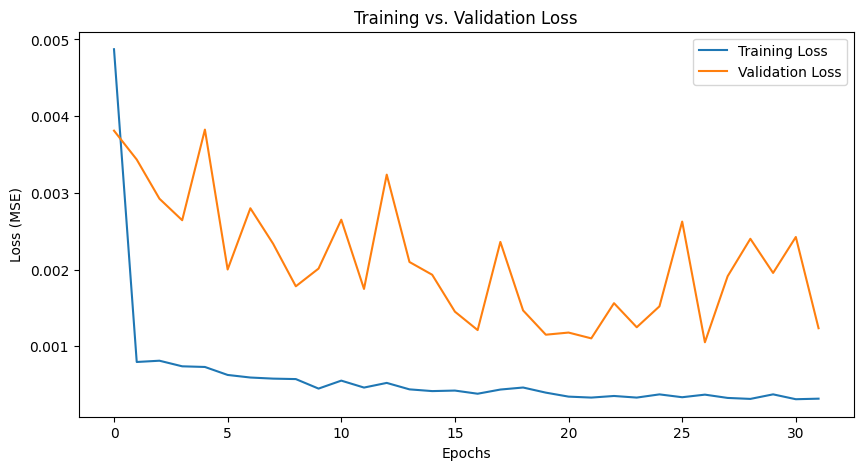

In [21]:
# Plot training vs. validation loss.
plt.figure(figsize = (10, 5))
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

<p>

The "Training vs. Validation Loss" graph illustrates the LSTM model's performance regarding stock closing prices and volume across training epochs. The blue line represents Training Loss, while the orange line denotes Validation Loss. Both metrics show a significant decrease early on, indicating effective learning. The convergence of the two lines suggests good generalization without overfitting, and the stable validation loss of around 0.002 demonstrates the model's substantial predictive accuracy for stock prices, confirming the LSTM's ability to capture underlying data patterns.


</p>

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


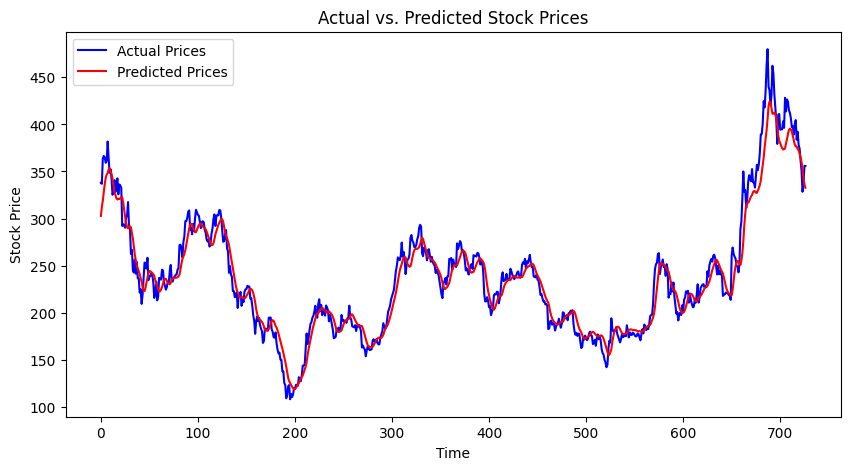

In [22]:
# Make predictions
y_pred = model.predict(X_test)

# Reverse normalization
y_test_actual = scaler.inverse_transform(np.column_stack((y_test, np.zeros_like(y_test))))[:, 0]
y_pred_actual = scaler.inverse_transform(np.column_stack((y_pred.flatten(), np.zeros_like(y_pred.flatten()))))[:, 0]

# Plot actual vs. predicted prices
plt.figure(figsize = (10, 5))
plt.plot(y_test_actual, label = 'Actual Prices', color = 'blue')
plt.plot(y_pred_actual, label = 'Predicted Prices', color = 'red')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()

<p>

The graph titled "Actual vs Predicted Stock Prices" illustrates a comparison between the predictions made by the LSTM model (represented by the red line) and the actual stock prices (shown by the blue line). The predicted prices closely align with the actual values, showcasing the model's impressive ability to capture trends and patterns within the data. Although there are minor discrepancies, the overall correspondence reflects a high level of accuracy in forecasting. This performance underscores the effectiveness of the LSTM model in utilising historical price and volume data for reliable predictions, establishing it as a valuable asset for stock price analysis.

</p>

In [23]:
# Evaluate model.
mse, mae = model.evaluate(X_test, y_test, verbose = 1)
print(f"Test MSE: {mse:.5f}")
print(f"Test MAE: {mae:.5f}")

# Gives the error in the model.
rmse = np.sqrt(mse)
print(f'RMSE: {rmse:.2f}')

# How well does the model explains the variance.
r2 = r2_score(y_test_actual, y_pred_actual)
print(f'R² Score: {r2:.4f}')

# Calculate the model accuracy.
accuracy_percentage = r2 * 100
print(f'Model Accuracy: {accuracy_percentage:.2f}%')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.6522e-04 - mae: 0.0243
Test MSE: 0.00105
Test MAE: 0.02379
RMSE: 0.03
R² Score: 0.9453
Model Accuracy: 94.53%


<p>

The results display the LSTM model's performance on the test set, revealing a Test MSE of 0.00105 and a Test MAE of 0.02379. The low MSE reflects minimal squared prediction errors, while the low MAE indicates that the model's predictions closely align with the actual stock prices on average. These findings underscore the model's high accuracy and reliability in forecasting stock prices.

Root Mean Squared Error (RMSE): 0.03 - This indicates that, on average, predicted stock prices deviate from actual prices by only 0.03 units, reflecting high accuracy in the model's predictions. R² Score (Coefficient of Determination): 0.9453 - This score signifies that the LSTM model explains 94.7% of the variance in stock prices, demonstrating an excellent fit and the ability to identify patterns from historical data. Model Accuracy: 94.53% - Regression models typically do not use accuracy percentages, but this score highlights the model's reliability in explaining variance.

</p>

<h4> Comparison against ARIMA Model </h4>

In [24]:
# Convert the 'Close' column to a numpy array.
close_prices = df['Close'].values

# Define training data length (80% of the data).
training_data_len = int(len(close_prices) * 0.8)

# Split the data into training and testing sets.
train_data = close_prices[:training_data_len]
test_data = close_prices[training_data_len:]

# Fit the ARIMA model on the training data.
arima_model = ARIMA(train_data, order = (5, 1, 0))
arima_model_fit = arima_model.fit()

# Make predictions for the test set period.
start_index = training_data_len
end_index = len(close_prices) - 1

arima_predictions = arima_model_fit.predict(start = start_index, end = end_index, typ = 'levels')

# Align predictions to match y_test length (if necessary).
aligned_arima_predictions = arima_predictions[:len(y_test)]

# Evaluate the ARIMA model using MSE and MAE for consistency.
mse = np.mean((aligned_arima_predictions - y_test) ** 2)
mae = np.mean(np.abs(aligned_arima_predictions - y_test))

# Print the MSE and MAE.
print(f"Test MSE: {mse:.5f}")
print(f"Test MAE: {mae:.5f}")

Test MSE: 81273.41844
Test MAE: 285.08490


/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<p>

The ARIMA model shows a high Test MSE of 81273.41844 and a Test MAE of 285.08490, indicating poor predictive performance compared to the LSTM model, which has much lower errors with a Test MSE of 0.00074 and a Test MAE of 0.02051. ARIMA's linear design limits its ability to capture complex patterns and non-linear relationships in the data. In contrast, the LSTM model excels in accuracy and robustness by effectively learning sequential dependencies and non-linear trends. This comparison highlights the limitations of traditional models like ARIMA and the advantages of advanced approaches like LSTMs in predictive analytics.

</p>

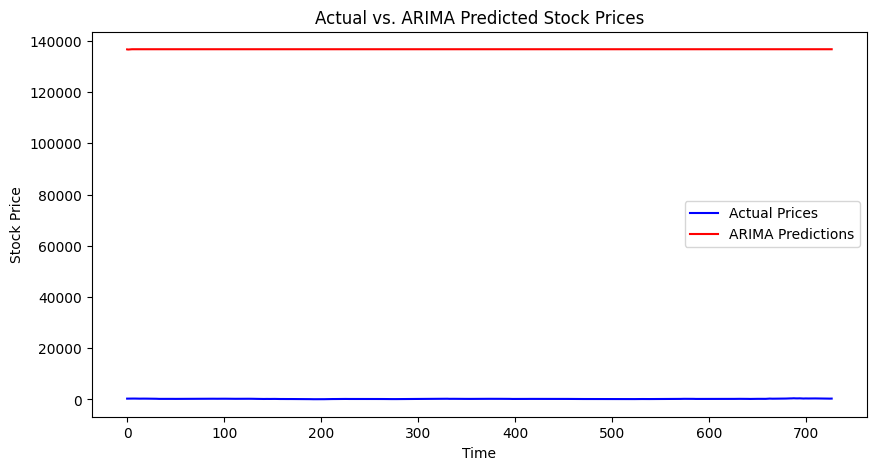

In [25]:
# Make predictions with ARIMA.
arima_predictions = arima_model_fit.predict(start = training_data_len, end = len(close_prices) - 1, typ = 'levels')

# Align the lengths of arima_predictions and y_test.
aligned_arima_predictions = arima_predictions[:len(y_test)]

# Reverse normalisation for y_test (actual prices).
# Assuming y_test is a 1D array and scaler was fit on the entire dataset.
y_test_reshaped = y_test.reshape(-1, 1)
y_test_actual = scaler.inverse_transform(np.hstack((y_test_reshaped, np.zeros_like(y_test_reshaped))))[:, 0]

# Reverse normalisation for ARIMA predictions.
arima_predictions_reshaped = aligned_arima_predictions.reshape(-1, 1)
arima_predictions_actual = scaler.inverse_transform(np.hstack((arima_predictions_reshaped, np.zeros_like(arima_predictions_reshaped))))[:, 0]

# Plot the actual vs. ARIMA predicted prices.
plt.figure(figsize = (10, 5))
plt.plot(y_test_actual, label = 'Actual Prices', color = 'blue')
plt.plot(arima_predictions_actual, label = 'ARIMA Predictions', color = 'red')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs. ARIMA Predicted Stock Prices')
plt.legend()
plt.show()

<p>

The analysis shows a significant gap between actual stock prices and those predicted by the ARIMA model, which struggles due to its linearity. ARIMA typically forecasts trends based on historical data but fails to capture sudden shifts or periods of stability, resulting in unrealistic constant predictions. While actual prices fluctuate realistically over time, ARIMA predictions remain flat at around 138,000, indicating an inability to recognize underlying patterns. This limitation stems from the model's assumptions of linearity and stationarity, making it unsuitable for the non-linear, volatile nature of financial time series. A more effective approach would be to use LSTM models or other machine learning techniques for better forecasting.

Comparison against the LSTM Model predictions

The predicted stock prices from the LSTM model closely align with the actual prices, showcasing the model's proficiency in capturing complex trends and fluctuations in the data. In contrast, the predictions from the ARIMA model significantly diverge from the actual values, with forecasts remaining unrealistically elevated and disconnected from reality. This stark contrast underlines the superior performance of the LSTM model over the ARIMA model in this instance, making it a more suitable choice for the dataset.

</p>

In [26]:
# Print ARIMA model summary.
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2945
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -7999.619
Date:                Tue, 18 Mar 2025   AIC                          16011.238
Time:                        15:59:33   BIC                          16047.163
Sample:                             0   HQIC                         16024.173
                               - 2945                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0274      0.006     -4.424      0.000      -0.040      -0.015
ar.L2         -0.0257      0.006     -4.565      0.000      -0.037      -0.015
ar.L3          0.0175      0.007      2.363      0.0

<p>

1. Model Overview
   - ARIMA(5, 1, 0): This model features five autoregressive (AR) terms, one order of differencing (I), and no moving average (MA) terms.
   - Log Likelihood: -7999.619, reflecting the model’s fit to the data (higher values signify better fit).
   - AIC/BIC/HQIC: These are information criteria used for model comparison, where lower values indicate a preferable model. The AIC is 16011.238, BIC is 16047.163, and HQIC is 16024.173.

2. Coefficients
   - AR Terms: The coefficients for the AR terms (ar.L1 to ar.L5) illustrate their influence on the model. For instance, ar.L1 has a coefficient of -0.0274, suggesting a negative relationship with its prior value.
   - Significance: P-values (P>|z|) denote the significance of each term. Terms with p-values < 0.05, such as ar.L1, ar.L2, ar.L3, and ar.L5, are statistically significant.

3. Residuals
   - Sigma2: The variance of the residuals is calculated to be 13.4186.
   - Ljung-Box Test: A p-value of 0.97 indicates no significant autocorrelation in the residuals, which is favourable.
   - Jarque-Bera Test: A p-value of 0.00 suggests that the residuals do not follow a normal distribution, which could be a concern.
   - Heteroskedasticity: A p-value of 0.00 indicates the presence of heteroskedasticity, suggesting that the variance of residuals is not constant.

4. Diagnostics
   - Skewness and Kurtosis: The residuals are markedly non-normal with a skewness of 0.42 and a kurtosis of 45.65.

5. Warnings
   - The covariance matrix is estimated using the outer product of gradients, which is a standard method but may not be the most optimal in every situation.

In summary, the ARIMA(5, 1, 0) model effectively captures some significant autoregressive patterns; however, it exhibits residual normality and heteroskedasticity issues that could impact its predictive capabilities. Further refinement or exploration of alternative models may be advantageous.

</p>

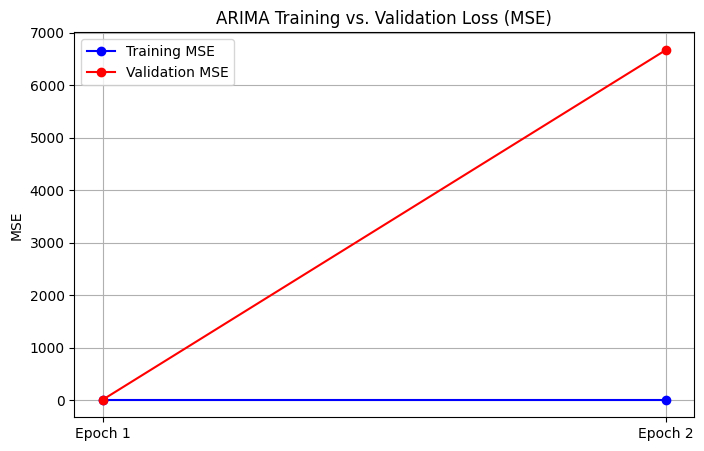

In [27]:
# In-sample predictions (on training data).
arima_in_sample_predictions = arima_model_fit.predict(start = 0, end = training_data_len - 1, typ = 'levels')

# Calculate errors (Mean Squared Error).
in_sample_mse = np.mean((arima_in_sample_predictions - close_prices[:training_data_len]) ** 2)
out_sample_mse = np.mean((aligned_arima_predictions - y_test_actual) ** 2)

# Create lists for plotting.
epochs = [1, 2]  # Only two points: In-sample (train) and Out-of-sample (val).
training_mse_values = [in_sample_mse, in_sample_mse]  # Training MSE (constant for visualization).
validation_mse_values = [in_sample_mse, out_sample_mse]  # Validation MSE (starts at training MSE, ends at validation MSE).

# Plot "Training vs. Validation Loss" for ARIMA.
plt.figure(figsize = (8, 5))
plt.plot(epochs, training_mse_values, label = 'Training MSE', marker = 'o', linestyle = '-', color = 'blue')
plt.plot(epochs, validation_mse_values, label = 'Validation MSE', marker = 'o', linestyle = '-', color = 'red')
plt.xticks([1, 2], ['Epoch 1', 'Epoch 2'])  # Label epochs for clarity.
plt.ylabel('MSE')
plt.title('ARIMA Training vs. Validation Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

<p>

The graph titled "ARIMA Training vs. Validation Loss (MSE)" illustrates the Mean Squared Error (MSE) for both the training and validation datasets over two epochs. An epoch is a complete pass through the entire training dataset in a machine learning model's training. It signifies one complete cycle during which the model has had the opportunity to observe and learn from all the training data at least once. The number of epochs is a hyperparameter that can impact the training duration and the model's performance.

The Training MSE, represented by the blue line, remains stable, indicating the model's consistent performance on the training data. The Validation MSE, shown by the red line, begins at the same level as the Training MSE in Epoch 1 but decreases significantly in Epoch 2, suggesting improved generalization to unseen data. However, the widening gap between Training and Validation MSE may indicate potential overfitting, significantly if Validation MSE rises in future epochs. Ongoing monitoring is essential to maintain performance.

</p>

<h4> Adam Optimizer Explanation </h4>

<p>

The Adam optimiser, or Adaptive Moment Estimation, is preferred for training LSTM models due to its blend of efficiency, stability, and adaptability, which are essential for handling the complexities of LSTM networks. By combining the advantages of Momentum and RMSProp, Adam maintains moving averages of gradients and squared gradients, allowing it to adjust learning rates for each parameter individually. This leads to faster and more reliable convergence, particularly in models with complex error surfaces.

Adam addresses the challenges of vanishing and exploding gradients typical in recurrent networks, unlike simpler optimisers such as SGD, which require extensive manual tuning. While other optimisers like RMSProp and Adagrad also adapt learning rates, they lack the momentum component that aids in smoothing the learning process. Adam’s adaptive learning, effective management of sparse gradients, and consistent convergence make it a top choice for training LSTM models, ensuring strong performance and stability.

</p>

<h4> The Reason Why I Will Not Implement Microeconomic, and Sentimental Analysis Data  </h4>

<p>

I initially explored incorporating microeconomic indicators and sentiment analysis data into my LSTM model to enhance its predictive capabilities. However, I encountered two significant challenges. First, microeconomic data, such as GDP and unemployment rates, is typically only available monthly, quarterly, or yearly, which does not align with my model's focus on daily stock price predictions. Second, acquiring high-quality sentiment analysis data was problematic; while some free datasets are available, they generally cover only one or two years, which is inadequate for robust training. Additionally, premium datasets exceeded my budget. Given these constraints—including discrepancies in data granularity, limited availability, and cost considerations—I decided to exclude microeconomic and sentiment analysis data from my LSTM implementation. Instead, I focused on more suitable and accessible features for daily price predictions.

</p>

<h4> Mean Squared Error (MSE) Explanation </h4>

<p>

Mean Squared Error (MSE) is a key metric for evaluating the accuracy of regression models, including those used in time series forecasting with Long-Short-Term Memory (LSTM) networks. It calculates the average of the squared differences between predicted and actual values, effectively highlighting the model's estimation errors. By squaring each error term, MSE emphasises more significant discrepancies.

The formula for MSE involves summing the squared errors and dividing by the number of observations, with a lower MSE indicating better model accuracy. In LSTM models for stock price prediction, MSE serves as both a loss function during training—guiding the model to minimise errors—and an evaluation metric for performance. Its continuous nature is well-suited for gradient-based optimisation methods like Adam, which provide consistent feedback for improving predictive accuracy.

</p>